<a href="https://colab.research.google.com/github/DustinMoriarty/jupyter-notebooks/blob/master/derivative_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Derivative Plot
Plot the derivatives of time series data from csv files. An example use case is an investigation into the velocity and acceleration behavior of a cylinder near the end of stroke. 

## Import Libraries
In python, we need to specify which libraries we plan to use.

In [1]:
import csv

from collections import namedtuple
from dataclasses import dataclass
from pathlib import Path
from typing import Dict
from typing import Text
from typing import TextIO
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np

## Create a Class to Store the Data
We need a place to store the data. We will use a simple dataclass with attributes which are numpy arrays. We will also add properties for the derivatives, `d1_value` and `d2_value`. There are many ways to store and manage your data. This implementation gives us a simple container which we can control.

In [2]:
@dataclass(frozen=True)
class TimeSeries:
    """
    Class for storing time series data. This class is immutable, which means 
    that once it is created, the data it contains cannot be changed.
    """
    time: np.ndarray
    value: np.ndarray
    label: Text

    def __post_init__(self):
        if len(self.time) != len(self.value):
            raise ValueError("All attributes must be the same length.")

    @property
    def d1_value(self) -> np.ndarray:
        """
        First derivative of value.
        """
        return np.gradient(self.value, self.time, edge_order=2)

    @property
    def d2_value(self) -> np.ndarray:
        """
        Second derivative of value.
        """
        return np.gradient(self.d1_value, self.time, edge_order=2)

## Define Functions
Define a function which can load data from a file into our new `TimeSeries` class.

In [3]:
def load_data(
    f: TextIO, label: Text, time_col_name="time", value_col_name="position"
) -> TimeSeries:
    """
    Load data from an IO stream.

    :param f: IO stream.
    :param label: Name of the time series (e.g. position, flow, etc.) to store with
        the new data set.
    :param time_col_name: The name of the column header used for time.
    :param value_col_name: Thge name of the column header used for value.
    :return: TimeSeries
    """
    reader = csv.DictReader(f)
    time = []
    position = []
    for row in reader:
        time.append(row[time_col_name])
        position.append(row[value_col_name])
    return TimeSeries(
        np.array(time, dtype=float), np.array(position, dtype=float), label
    )

Define a function to plot the data.

In [4]:
def plot(
    *time_series: TimeSeries,
    x_axis_attr: Text = "time",
    value_name: Text = "value",
    value_unit: Text = "in.",
    value_symbol: Text = "y",
    time_unit: Text = "s",
) -> plt.Figure:
    """
    Plot one or more time series on the same figure.

    :param time_series: Time series to plot.
    :param x_axis_attr: The attribute to plot on the x-axis. Choices are time or value.
        If time is selected, then three subplots are created. If value is selected,
        then two subplots are created.
    :param value_name: The name to use for the value on plots.
    :param value_unit: The unit of measure for the value on plots.
    :param value_symbol: The symbol to use for the value on plots.
    :param time_unit: The unit of measure to use for time on plots.
    :return: Figure
    """
    # Handle our configurable x-axis.
    LabelData = namedtuple("LabelData", ["name", "unit", "symbol"])
    x_axis_labels: Dict[Text, LabelData] = {
        "value": LabelData(value_name, value_unit, value_symbol),
        "time": LabelData("time", time_unit, "t"),
    }
    if x_axis_attr not in x_axis_labels.keys():
        raise ValueError(
            f"x_axis_attr {x_axis_attr} not one of {tuple(x_axis_labels.keys())}"
        )
    n_plots = 2 if x_axis_attr == "value" else 3

    # Create a figure.
    fig, ax = plt.subplots(n_plots, sharex=True, figsize=(6,7))

    # Plot the data.
    for ts in time_series:
        x_data = getattr(ts, x_axis_attr)
        ax[0].plot(x_data[3:-3], ts.d2_value[3:-3], label=ts.label)
        ax[1].plot(x_data[3:-3], ts.d1_value[3:-3], label=ts.label)
        if n_plots == 3:
            ax[2].plot(x_data, ts.value, label=ts.label)

    # Add annotations to the plots.
    label_data = x_axis_labels[x_axis_attr]
    ax[0].set_ylabel(
        f"$\\frac{{d^2{value_symbol}}}{{dt^2}}$ $(\\frac{{{value_unit}}}{{{time_unit}^2}})$",
        fontsize=18
    )
    ax[1].set_ylabel(
        f"$\\frac{{d{value_symbol}}}{{dt}}$ $(\\frac{{{value_unit}}}{{{time_unit}}})$",
        fontsize=18
    )
    if n_plots == 3:
        ax[2].set_ylabel(
            f"${value_symbol}$ $({value_unit})$"
        )
    ax[-1].set_xlabel(
        f"${label_data.symbol}$ $({label_data.unit})$", 
        fontsize=18
    )
    ax[-1].legend()
    fig.suptitle(f"Derivatives of {value_name.title()} vs. {label_data.name.title()}")
    return fig

## Put It All Together

Define a function which can plot one or more files.

In [5]:
def plot_files(
    *file: Tuple[Text],
    time_col_name: Text = "time",
    value_col_name: Text = "value",
    x_axis_attr: Text = "time",
    value_name: Text = "value",
    value_symbol: Text = "y",
    value_unit: Text = "in.",
    time_unit: Text = "s",
):
    """
    Plot files.
    """
    data = []
    for this_file in file:
        this_file_path = Path(this_file)
        with this_file_path.open() as f:
            time_series: TimeSeries = load_data(
                f,
                label=this_file_path.stem,
                time_col_name=time_col_name,
                value_col_name=value_col_name,
            )
            data.append(time_series)
    fig = plot(
        *data,
        x_axis_attr=x_axis_attr,
        value_name=value_name,
        value_unit=value_unit,
        value_symbol=value_symbol,
        time_unit=time_unit
    )
    fig.show()

# Generate Example Data Files.
Make a couple files so that we can show how a file can be loaded. These files will show an example of a typical cushioned cylinder stroke with an acceleration and deceleration phase. The example data mimicks a typical actuator cycle with an acceleration, constant velocity and deceleration component.

In [6]:
def integrate(y, dt):
    return np.array([np.trapz(y[0:n], dx=dt) for n in range(len(y))])

def create_example_data():
    np.random.seed(1234)
    dt = 0.02
    size = 500
     # Start with the second derivative discontinuous funciton and integrate 
     # back to x to get a continuous function.
     # Add some random numbers in order to make the data more like 
     # real world data.
    d2x = np.array(
            [0]*10
            + [1] * int(size / 3) 
            + [0] * int(size / 3) 
            + [-1] * int(size / 3)
            +[0]*10
            )
    d2x =  d2x + np.array([np.random.random()*1e-12 for x in range(d2x.size)])
    t = np.arange(0, len(d2x)) * dt + np.array([np.random.random()*1e-12 for x in range(d2x.size)])
    d1x = integrate(d2x, dt)
    x = integrate(d1x, dt)
    np.savetxt(
        "test_data_0.csv",
        np.array([t, x]).transpose(),
        fmt="%0.16f",
        header="Time,Position",
        delimiter=",",
        comments="",
    )
    dt = 0.02
    size = 400
    d2x = np.array(
        [0]*10
        + [1.8] * int(size / 4) 
        + [0] * int(size / 2) 
        + [-1.8] * int(size / 4)
        + [0]*10
        )
    t = np.arange(0, len(d2x)) * dt
    d1x = integrate(d2x, dt) + 0.1
    x = integrate(d1x, dt)
    np.savetxt(
        "test_data_1.csv",
        np.array([t, x]).transpose(),
        fmt="%0.16f",
        header="Time,Position",
        delimiter=",",
        comments="",
    )

create_example_data()

## Plot the Example Data

We can plot the example files. Here we see the derivative values compared to time. This is the typical way we are familiar with seeing derivatives plotted from a calculus class.

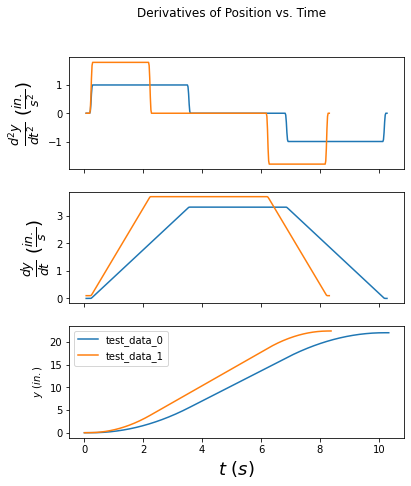

In [7]:
plot_files("test_data_0.csv", "test_data_1.csv", time_col_name="Time", value_col_name="Position", x_axis_attr="time", value_name="position", value_unit="in.")

Plot the data with the position on the x axis instead of time. This may be more useful if we are more concerned about the location in a cycle where acceleration or deceleration occurs. For this plot, only two subplots are generated because there is not need to plot position versus position.

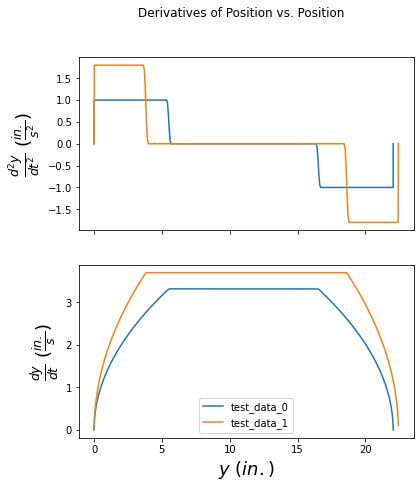

In [8]:
plot_files("test_data_0.csv", "test_data_1.csv", time_col_name="Time", value_col_name="Position", x_axis_attr="value", value_name="position", value_unit="in.")